# Importing Necessary modules

In [102]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from xml.etree import ElementTree as ET
import sqlite3 as sql


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Importing Data

In [2]:
db = sql.connect("database.sqlite")
league_ids = pd.read_sql("SELECT * FROM League", db)
league_ids

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [3]:
chosen_id = 1729
match_data = pd.read_sql_query(f"SELECT season, date, home_team_api_id, (SELECT team_long_name FROM Team WHERE home_team_api_id = team_api_id) as home_team_name, away_team_api_id, (SELECT team_long_name FROM Team WHERE away_team_api_id = team_api_id) as away_team_name, home_team_goal, away_team_goal, shoton, shotoff, foulcommit, card, cross, corner, possession, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA FROM Match WHERE league_id = {chosen_id} ORDER BY date", db)


In [4]:
match_data

,season,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,shoton,shotoff,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,2008/2009,2008-08-16 00:00:00,9825,Arsenal,8659,West Bromwich Albion,1,0,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,12.00,1.25,6.00,13.00,1.22,5.50,13.00,1.22,5.00,13.00
1,2008/2009,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,1.73,5.50,3.80,1.65,5.00,3.40,1.70,4.50,3.40,1.73
2,2008/2009,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,1,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,3.75,1.90,3.50,4.35,1.91,3.25,4.00,1.91,3.25,3.80
3,2008/2009,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,3,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,3.40,2.05,3.30,4.00,2.00,3.25,3.75,2.00,3.25,3.50
4,2008/2009,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,2.20,3.20,3.40,2.30,3.00,3.25,2.30,2.80,3.25,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,2015/2016,2016-05-15 00:00:00,10194,Stoke City,8654,West Ham United,2,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,NaN,3.50,3.80,2.10,NaN,NaN,NaN,NaN,NaN,NaN
3036,2015/2016,2016-05-15 00:00:00,10003,Swansea City,8456,Manchester City,1,1,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,NaN,5.20,4.75,1.53,NaN,NaN,NaN,NaN,NaN,NaN
3037,2015/2016,2016-05-15 00:00:00,9817,Watford,8472,Sunderland,2,2,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,NaN,2.05,3.75,3.70,NaN,NaN,NaN,NaN,NaN,NaN
3038,2015/2016,2016-05-15 00:00:00,8659,West Bromwich Albion,8650,Liverpool,1,1,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,NaN,2.38,3.60,3.00,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

## Averaging the betting odds data

In [5]:
bettings_odds_names = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
home_odds_names = [str(name + 'H') for name in bettings_odds_names]
draw_odds_names = [str(name + 'D') for name in bettings_odds_names]
away_odds_names = [str(name + 'A') for name in bettings_odds_names]

In [6]:
match_data['odds_home_winning'] = match_data[home_odds_names].mean(axis=1)
match_data['odds_draw'] = match_data[draw_odds_names].mean(axis=1)
match_data['odds_home_losing'] = match_data[away_odds_names].mean(axis=1)

In [7]:
match_data.drop(columns=(home_odds_names + draw_odds_names + away_odds_names), inplace=True)

## Extracting xml data from the necessary columns

In [8]:
def extract_xml_data(xml_document, home_team, away_team, card_type='y'):
    root = ET.fromstring(xml_document)
    stat_home_team = 0
    stat_away_team = 0
    
    #Dealing with card type using the root element & the card type argument
    if root.tag == 'card':
        for child in root.iter('value'):
            #Some xml docs have no card_type element in the tree. comment section seems to have that information
            try:
                if child.find('comment').text == card_type:
                    if int(child.find('team').text) == home_team:
                        stat_home_team += 1
                    else:
                        stat_away_team += 1
            except AttributeError:
                #Some values in the xml doc don't have team values, so there isn't much we can do at this stage
                pass
                
        return stat_home_team - stat_away_team
    
    #Lets take the last possession stat which is available from the xml doc
    if root.tag == 'possession':
        try:
            last_value = [child for child in root.iter('value')][-1]
            return int(last_value.find('homepos').text) - int(last_value.find('awaypos').text)
        except:
            return None
    
    #Taking care of all other stats by extracting based on the home team & away team api id's
    for team in [int(stat.text) for stat in root.findall('value/team')]:
        if team == home_team: 
            stat_home_team += 1
        else:
            stat_away_team += 1
    return stat_home_team - stat_away_team

In [9]:
match_data['on_target_shot'] = match_data[['shoton','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['shoton'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
match_data['off_target_shot'] = match_data[['shotoff','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['shotoff'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand") 
match_data['foul'] = match_data[['foulcommit','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['foulcommit'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
match_data['yellow_card'] = match_data[['card','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['card'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")
match_data['red_card'] = match_data[['card','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['card'],x['home_team_api_id'],x['away_team_api_id'], card_type='r'), axis = 1,result_type="expand")  
match_data['crosses'] = match_data[['cross','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['cross'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
match_data['corners'] = match_data[['corner','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['corner'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")  
match_data['possessions'] = match_data[['possession','home_team_api_id','away_team_api_id']].apply(lambda x: extract_xml_data(x['possession'],x['home_team_api_id'],x['away_team_api_id']), axis = 1,result_type="expand")

In [10]:
match_data.drop(columns=['shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'], inplace=True)

## Defining a result column

In [11]:
match_data.loc[match_data['home_team_goal'] > match_data['away_team_goal'], 'result'] = 'win'
match_data.loc[match_data['home_team_goal'] == match_data['away_team_goal'], 'result'] = 'draw'
match_data.loc[match_data['home_team_goal'] < match_data['away_team_goal'], 'result'] = 'lose'

## Removing any rows containing N/A value

In [12]:
match_data.dropna(axis=0, inplace=True)
match_data

,season,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,odds_home_winning,odds_draw,odds_home_losing,on_target_shot,off_target_shot,foul,yellow_card,red_card,crosses,corners,possessions,result
0,2008/2009,2008-08-16 00:00:00,9825,Arsenal,8659,West Bromwich Albion,1,0,1.208889,5.522222,12.222222,10,10,2,0,0,14,2,32.0,win
1,2008/2009,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,1,4.925556,3.450000,1.671111,-7,-2,1,-2,0,-4,-7,-8.0,lose
2,2008/2009,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,1,1.874444,3.283333,3.938889,-2,-8,1,1,0,-12,-4,4.0,win
3,2008/2009,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,3,1.961111,3.233333,3.716667,-6,-1,0,0,0,-7,-1,2.0,lose
4,2008/2009,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,2.942222,3.277778,2.244444,5,0,0,-1,0,-2,-2,6.0,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,2015/2016,2016-05-15 00:00:00,10194,Stoke City,8654,West Ham United,2,1,3.368571,3.538571,2.152857,-7,-5,-4,2,0,-5,-6,-10.0,win
3036,2015/2016,2016-05-15 00:00:00,10003,Swansea City,8456,Manchester City,1,1,6.058571,4.492857,1.510000,-4,-10,-14,-2,0,-1,0,0.0,draw
3037,2015/2016,2016-05-15 00:00:00,9817,Watford,8472,Sunderland,2,2,2.054286,3.628571,3.582857,4,8,1,1,0,-3,3,-2.0,draw
3038,2015/2016,2016-05-15 00:00:00,8659,West Bromwich Albion,8650,Liverpool,1,1,2.407143,3.500000,2.902857,2,5,-1,2,0,-2,2,-34.0,draw


# Analysing Data

In [13]:
match_data.columns

Index(['season', 'date', 'home_team_api_id', 'home_team_name',
       'away_team_api_id', 'away_team_name', 'home_team_goal',
       'away_team_goal', 'odds_home_winning', 'odds_draw', 'odds_home_losing',
       'on_target_shot', 'off_target_shot', 'foul', 'yellow_card', 'red_card',
       'crosses', 'corners', 'possessions', 'result'],
      dtype='object')

In [14]:
describe_data = match_data.drop(columns=['season', 'date', 'home_team_api_id', 'home_team_name', 'away_team_api_id', 'away_team_name'])

In [15]:
describe_data.describe()

,home_team_goal,away_team_goal,odds_home_winning,odds_draw,odds_home_losing,on_target_shot,off_target_shot,foul,yellow_card,red_card,crosses,corners,possessions
count,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000,3034.000000
mean,1.552736,1.158207,2.640177,3.829852,4.679429,1.406724,1.397495,-0.707976,-0.386618,-0.011206,4.665458,1.314766,3.353988
std,1.311651,1.143808,1.570588,0.878952,3.513701,4.990730,4.469430,4.671019,1.597837,0.305796,11.931216,4.616746,17.281878
min,0.000000,0.000000,1.092222,3.020000,1.235556,-16.000000,-14.000000,-18.000000,-6.000000,-2.000000,-41.000000,-16.000000,-92.000000
25%,1.000000,0.000000,1.665667,3.288889,2.461111,-2.000000,-2.000000,-4.000000,-1.000000,0.000000,-3.000000,-2.000000,-8.000000
50%,1.000000,1.000000,2.144444,3.456349,3.450000,1.000000,1.000000,-1.000000,0.000000,0.000000,4.000000,1.000000,4.000000
75%,2.000000,2.000000,2.891071,3.965799,5.344222,4.000000,4.000000,3.000000,1.000000,0.000000,12.000000,4.000000,14.000000
max,9.000000,6.000000,12.500000,9.194444,23.555556,25.000000,19.000000,14.000000,5.000000,2.000000,66.000000,19.000000,60.000000


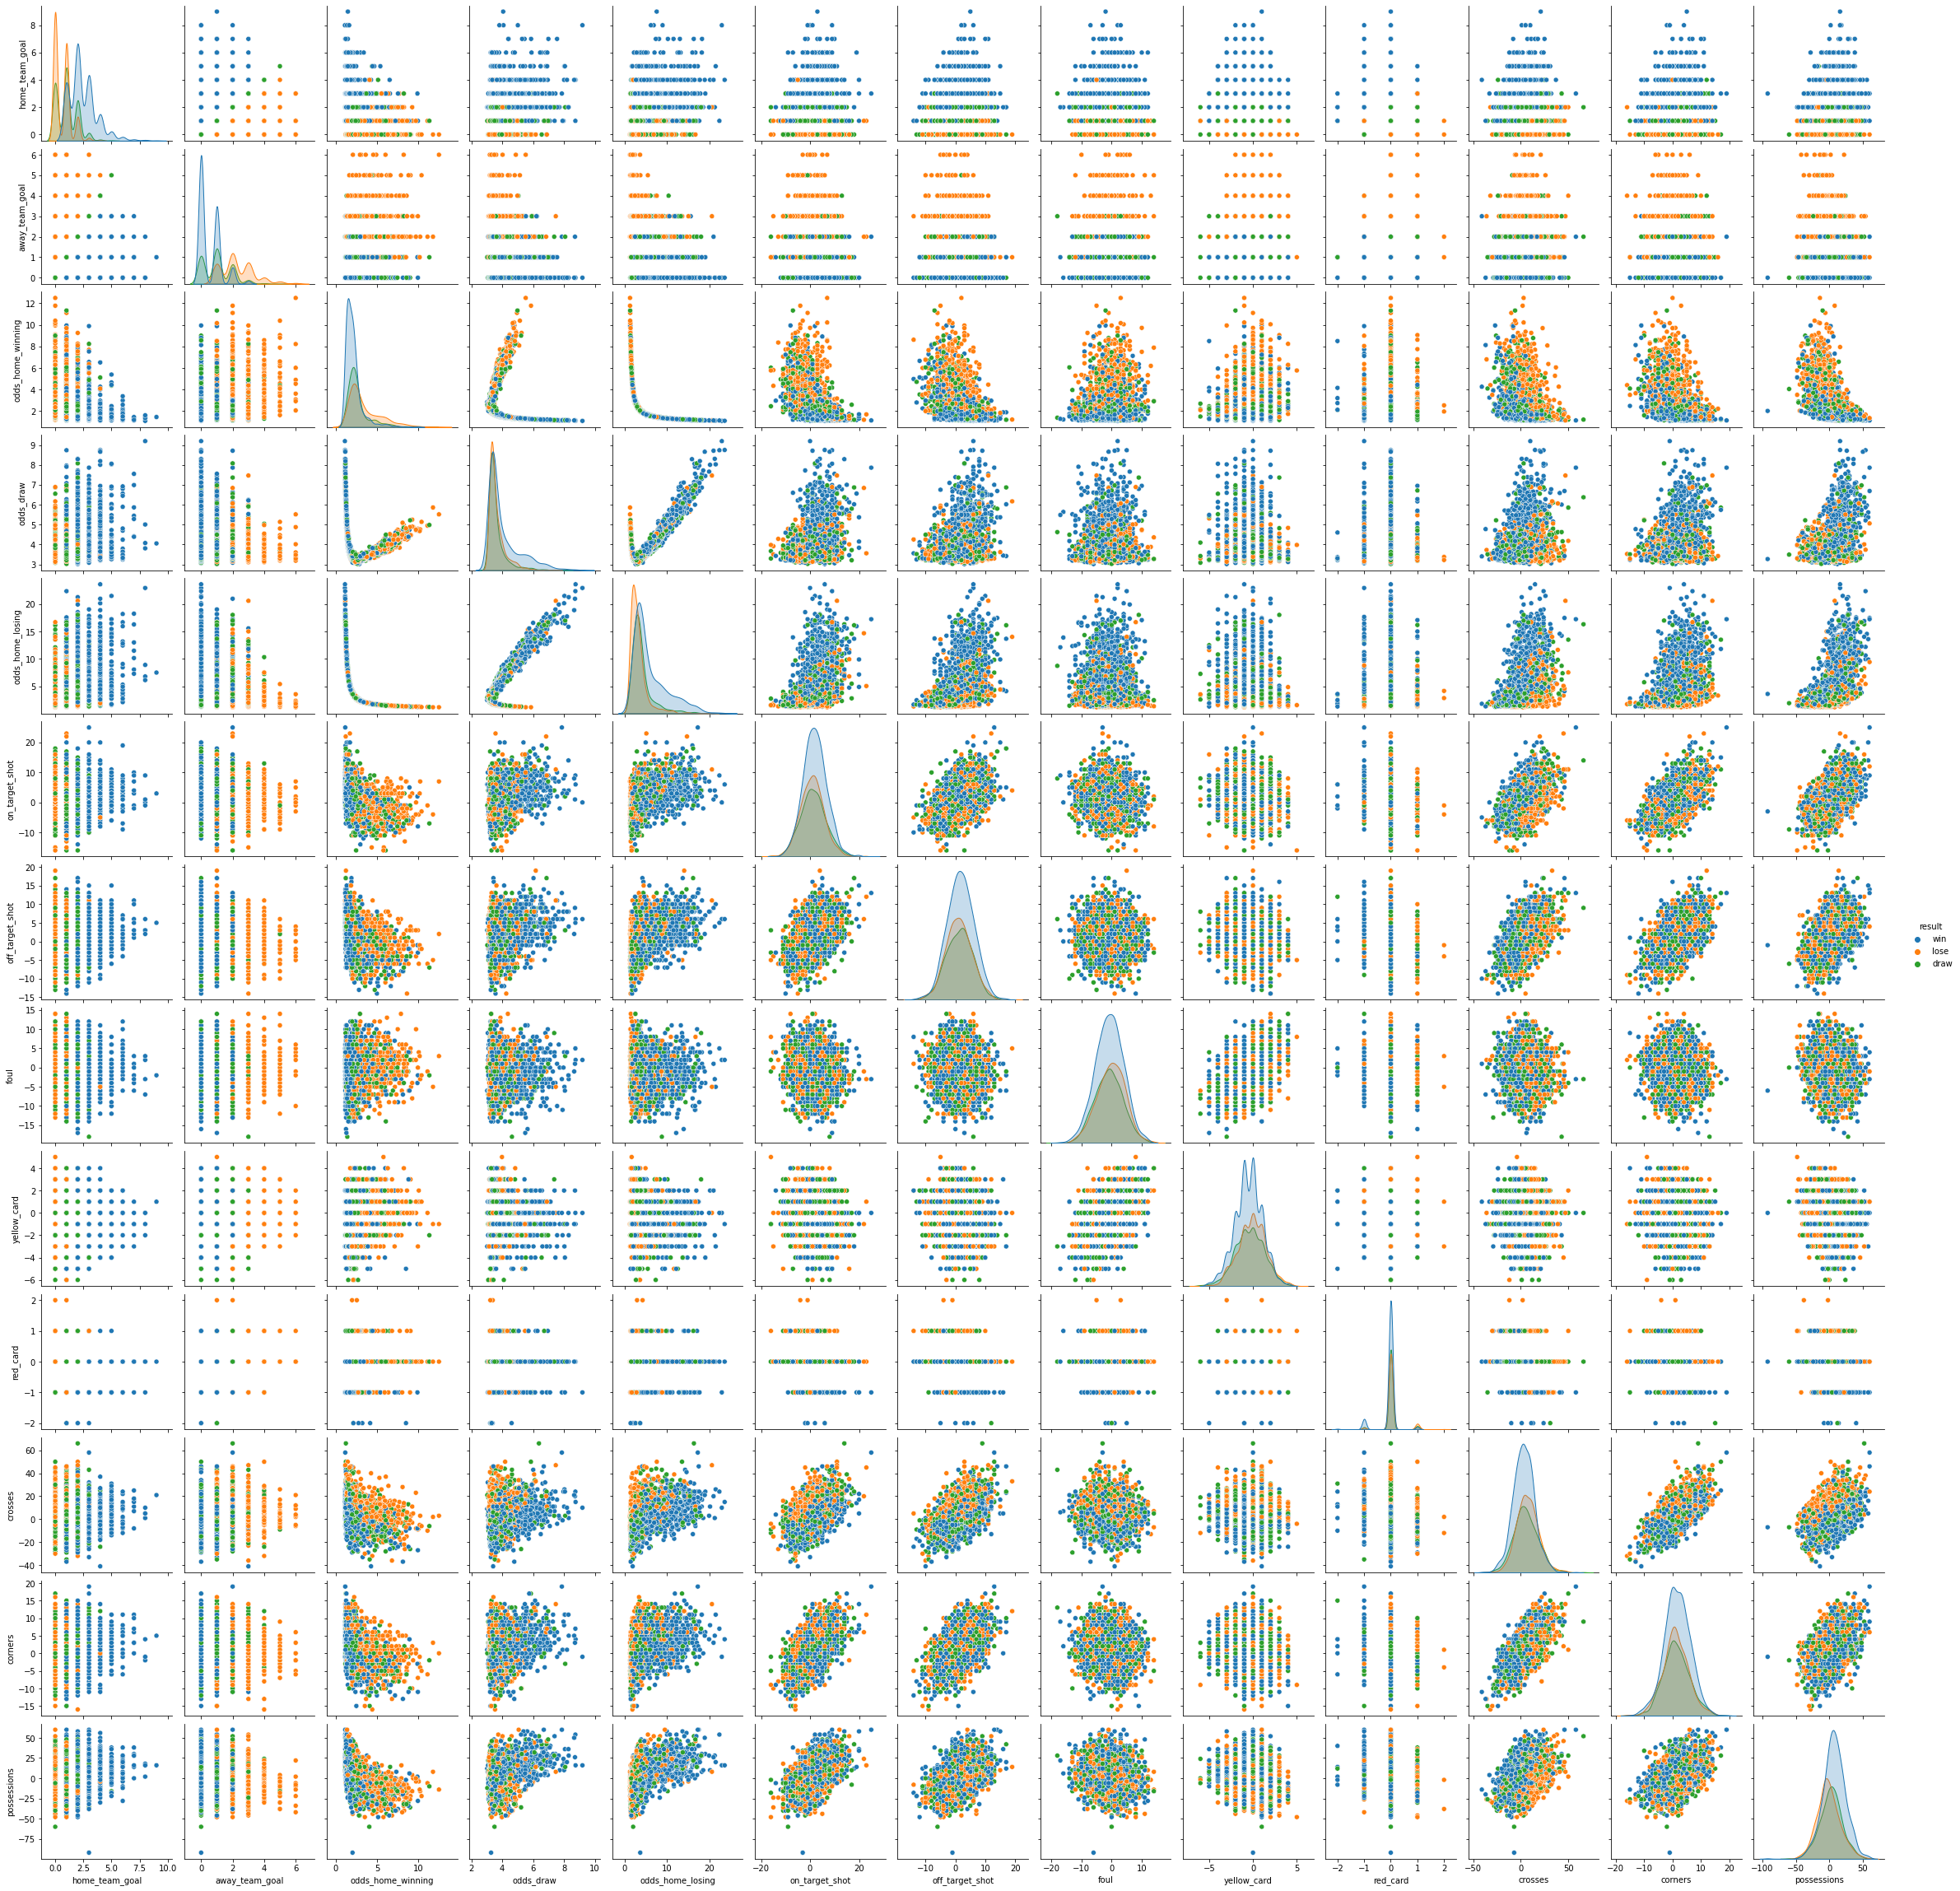

In [35]:
sns.pairplot(describe_data, hue='result')

# Testing differents models

In [74]:
df = match_data
y = df['result']
X = df.loc[:, 'odds_home_winning':'possessions']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

In [103]:
# Building models
models = []
models.append(('LR', LogisticRegression(random_state=0, max_iter=1000, solver='saga')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(random_state=0)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0)))

## Models evaluation using kfold and cross validation

In [104]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


LR: 0.525387 (0.027517)
LDA: 0.527427 (0.031012)
CART: 0.380025 (0.034982)
NB: 0.504937 (0.048932)
SVM: 0.510163 (0.031685)
RFC: 0.475510 (0.049887)


## Tuning best models to find the best one

In [108]:
models.clear()

In [109]:
models.append(('LR', LogisticRegression(random_state=0, max_iter=1000, solver='saga')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=0)))

params = []
params.append({'C': np.arange(0.1, 0.3, 0.05), 'multi_class': ('ovr', 'multinomial')})
params.append({'solver': ('svd', 'lsqr', 'eigen')})
params.append({})
params.append({'C': np.arange(0.1, 0.3, 0.05), 'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

zip_models = zip(models, params)
dict_models = dict(zip_models)

In [110]:
def testing_model(dict_models, X_train, y_train):

    for model, params in dict_models.items():
        print(f'Finding best parameters for {model[0]}...')
        param_search = GridSearchCV(estimator=model[1], param_grid=params, verbose=1)
                        
        param_search.fit(X_train, y_train)

        best_score = param_search.best_score_
        best_params = param_search.best_params_

        print(f'Best accuracy: {best_score} was obtained with parameters: {best_params}')

In [111]:
testing_model(dict_models, X_train, y_train)

Finding best parameters for LR...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best accuracy: 0.5304672122656169 was obtained with parameters: {'C': 0.1, 'multi_class': 'ovr'}
Finding best parameters for LDA...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best accuracy: 0.5243758417072413 was obtained with parameters: {'solver': 'svd'}
Finding best parameters for NB...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best accuracy: 0.49385165233606126 was obtained with parameters: {}
Finding best parameters for SVM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best accuracy: 0.5294416243654823 was obtained with parameters: {'C': 0.1, 'kernel': 'linear'}


# Results

In [82]:
def make_pred_and_show_results(model, X_train, y_train, X_test, y_test, confusion_matrix=True, hist=True):
    ## Fit model and make predictions
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    ## Accuracy score for train and test set
    print(f"Accuracy score for train set : {accuracy_score(y_train, train_pred)} ({round(accuracy_score(y_train, train_pred)*100, 2)}%)")
    print(f"Accuracy score for test set : {accuracy_score(y_test, test_pred)} ({round(accuracy_score(y_test, test_pred)*100, 2)}%)")

    ## Plot histogram
    if hist:
        sns.histplot(data=y_test, color='red', label='y_test')
        sns.histplot(data=test_pred, color='skyblue', label='y_true')
        plt.legend()

    ## Plot confusions matrixes
    if confusion_matrix:
        f, axs = plt.subplots(2,2, figsize=(15,15))
        axs = axs.flatten()

        options = [
            ("Confusion matrix for train set", None, y_train, train_pred),
            ("Normalized confusion matrix for train set", "true", y_train, train_pred),
            ("Confusion matrix for test set", None, y_test, test_pred),
            ("Normalized confusion matrix for test set", "true", y_test, test_pred)  
        ]

        for index, (title, normalize, y, pred) in enumerate(options):
            matrix = ConfusionMatrixDisplay.from_predictions(y, pred, labels=['win', 'draw', 'lose'], normalize=normalize, cmap=plt.cm.Blues, ax=axs[index])
            matrix.ax_.set_title(title)

## SVC

In [112]:
df = match_data
y = df['result']
X = df.loc[:, 'odds_home_winning':'possessions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

Accuracy score for train set : 0.5789039967037495 (57.89%)
Accuracy score for test set : 0.5799011532125206 (57.99%)


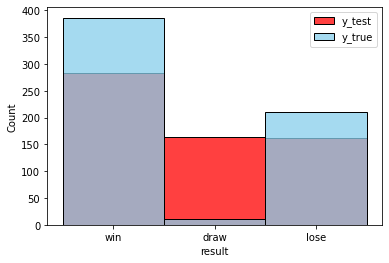

In [113]:
svc1 = SVC(C=0.1, kernel='linear', random_state=0)
make_pred_and_show_results(svc1, X_train, y_train, X_test, y_test, confusion_matrix=False)

### Finding the best number of matches to use for the model

In [85]:
def best_number_of_matches(match_data, model, nb_of_matches):
    accuracy_dict = {}
    for n in nb_of_matches:
        if n > len(match_data):
            n = len(match_data)
        df = match_data[-n:]
        y_nb = df['result']
        X_nb = df.loc[:, 'odds_home_winning':'possessions']
        X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, test_size=0.20, random_state=1, shuffle=True)
        model.fit(X_train_nb, y_train_nb)
        pred = model.predict(X_test_nb)
        accuracy_dict[n] = accuracy_score(y_test_nb, pred)
    return max(accuracy_dict, key=accuracy_dict.get)

In [86]:
nb_of_matches = range(100,3000,10)
max_nb_of_matches = best_number_of_matches(df, svc1, nb_of_matches)
max_nb_of_matches

1010

### Using 1010 previous matches

In [87]:
df = match_data[-max_nb_of_matches:]
y = df['result']
X = df.loc[:, 'odds_home_winning':'possessions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

Accuracy score for train set : 0.6064356435643564 (60.64%)
Accuracy score for test set : 0.6732673267326733 (67.33%)


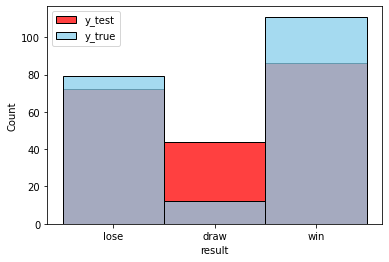

In [88]:
svc2 = SVC(C=0.1, kernel='linear', random_state=0)
make_pred_and_show_results(svc2, X_train, y_train, X_test, y_test, confusion_matrix=False)

### Not using betting odds

In [89]:
df = match_data[-max_nb_of_matches:]

y = df['result']
X = df.loc[:, 'on_target_shot':'possessions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

Accuracy score for train set : 0.5594059405940595 (55.94%)
Accuracy score for test set : 0.599009900990099 (59.9%)


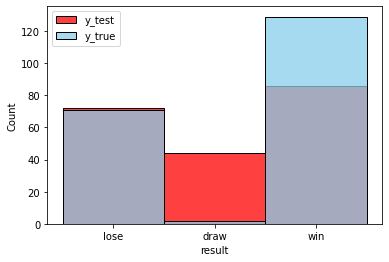

In [90]:
svc3 = SVC(C=0.1, kernel='linear', random_state=0)
make_pred_and_show_results(svc3, X_train, y_train, X_test, y_test, confusion_matrix=False)

## Linear Discriminant Analysis

In [91]:
df = match_data
y = df['result']
X = df.loc[:, 'odds_home_winning':'possessions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)


Accuracy score for train set : 0.5904408735063865 (59.04%)
Accuracy score for test set : 0.5799011532125206 (57.99%)


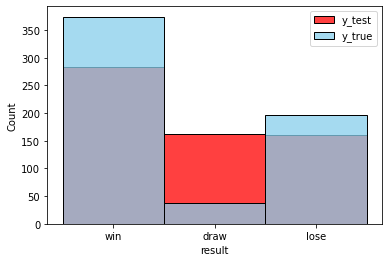

In [92]:
lda1 = LinearDiscriminantAnalysis(solver='lsqr')
make_pred_and_show_results(lda1, X_train, y_train, X_test, y_test, confusion_matrix=False)

### Finding the best number of matches to use for the model

In [93]:
nb_of_matches = range(100,3000,10)
max_nb_of_matches = best_number_of_matches(df, lda1, nb_of_matches)
max_nb_of_matches

1230

### Using 1230 previous matches

In [94]:
df = match_data[-max_nb_of_matches:]

y = df['result']
X = df.loc[:, 'odds_home_winning':'possessions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

Accuracy score for train set : 0.5955284552845529 (59.55%)
Accuracy score for test set : 0.6788617886178862 (67.89%)


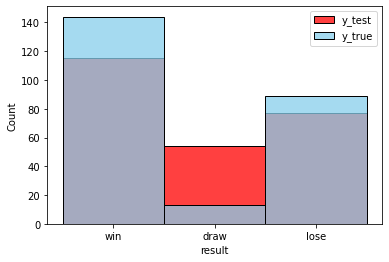

In [95]:
lda2 = LinearDiscriminantAnalysis(solver='lsqr')
make_pred_and_show_results(lda2, X_train, y_train, X_test, y_test, confusion_matrix=False)

### Not using betting odds

In [96]:
df = match_data[-max_nb_of_matches:]

y = df['result']
X = df.loc[:, 'on_target_shot':'possessions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

Accuracy score for train set : 0.532520325203252 (53.25%)
Accuracy score for test set : 0.5813008130081301 (58.13%)


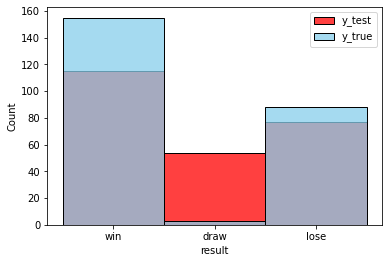

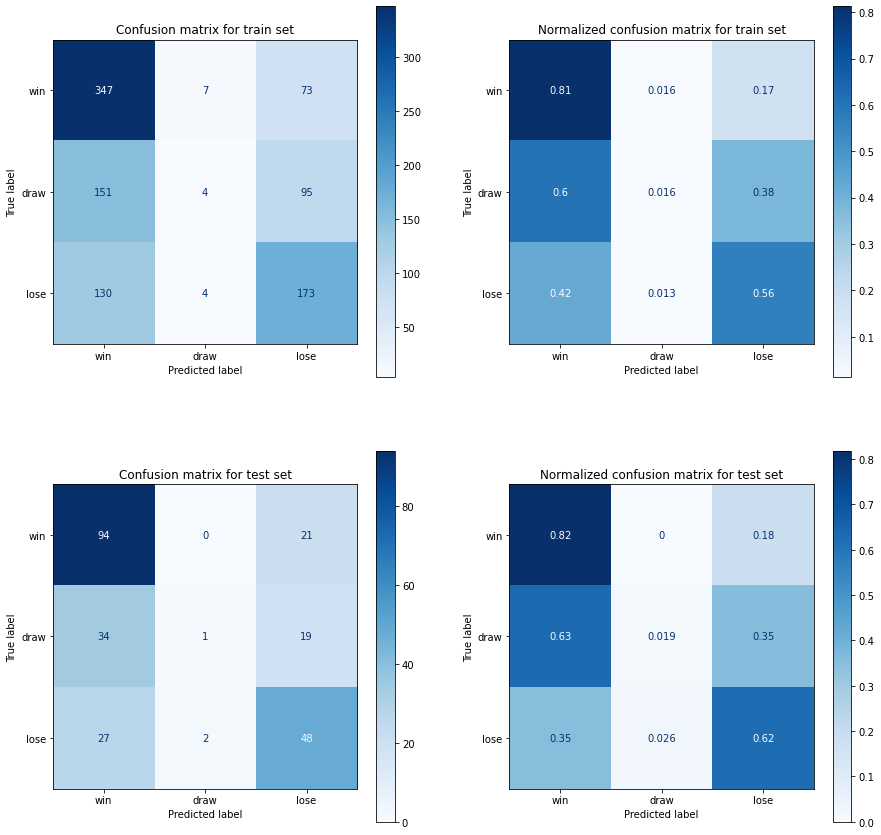

In [97]:
lda3 = LinearDiscriminantAnalysis(solver='lsqr')
make_pred_and_show_results(lda3, X_train, y_train, X_test, y_test, confusion_matrix=True)